In [1]:
from keras.models import load_model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
import keras.backend as K
from keras import activations

from vis.utils import utils
from vis.visualization import visualize_saliency

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os, random


Using TensorFlow backend.


In [2]:
IMG_SIZE = 299
img_shape = (IMG_SIZE, IMG_SIZE, 3)

model = load_model('/Users/yueying.teng/Documents/indoor_gps/models/2018-12-19_fulldata_gps_xception_model_0.01_midway.h5')


In [4]:

def load_img(img_dir):
    img_img = image.load_img(img_dir, target_size = (IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img_img)
    img_processed = preprocess_input(img)

    return img_processed


In [24]:
# randomly generate 5 image directories
classes = []
for i in np.random.randint(76, size = 5):
    classes.append('{:04d}'.format(i + 1))
    
img_path = []

for i in classes:
    class_dir = '/Users/yueying.teng/Documents/indoor_gps/data/test/class_' + i
    img = random.choice(os.listdir(class_dir))
    img_dir = os.path.join(class_dir, img)
    img_path.append(img_dir)

img_path


['/Users/yueying.teng/Documents/indoor_gps/data/test/class_0040/frame_0549.jpg',
 '/Users/yueying.teng/Documents/indoor_gps/data/test/class_0046/frame_0523.jpg',
 '/Users/yueying.teng/Documents/indoor_gps/data/test/class_0022/frame_0261.jpg',
 '/Users/yueying.teng/Documents/indoor_gps/data/test/class_0036/frame_0736.jpg',
 '/Users/yueying.teng/Documents/indoor_gps/data/test/class_0023/frame_0834.jpg']

In [25]:
# image directory class index starts from 1, but model prediction starts from index 0
pred_label = []

for i in img_path:
    img_processed = load_img(i)
    predictions = model.predict(img_processed[np.newaxis, :])
    pred_label.append(np.argmax(predictions[0]))
    
pred_label


[39, 45, 21, 35, 22]

In [26]:

# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model, 'dense_4')

# Swap softmax with a linear activation
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


In [20]:
# test_heatmap = np.mean(conv_layer_output_value, axis=-1)

# plt.imshow(test_heatmap)
# plt.colorbar()

In [27]:

def get_grad_cam(class_idx, img_processed, img_path):
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("block14_sepconv2_act")

    # gradients, gradient of the class score w.r.t pixel values in all feature map 
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    # weights, global pooling average of the calcualted gradients from each feature map
    pooled_grads = K.mean(grads, axis = (0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img_processed[np.newaxis, :]])

    # feature maps are weighted using the weights calculated in pooled_grads
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # average the weighted feature maps through all channels 
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    gradcam_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return(gradcam_img)


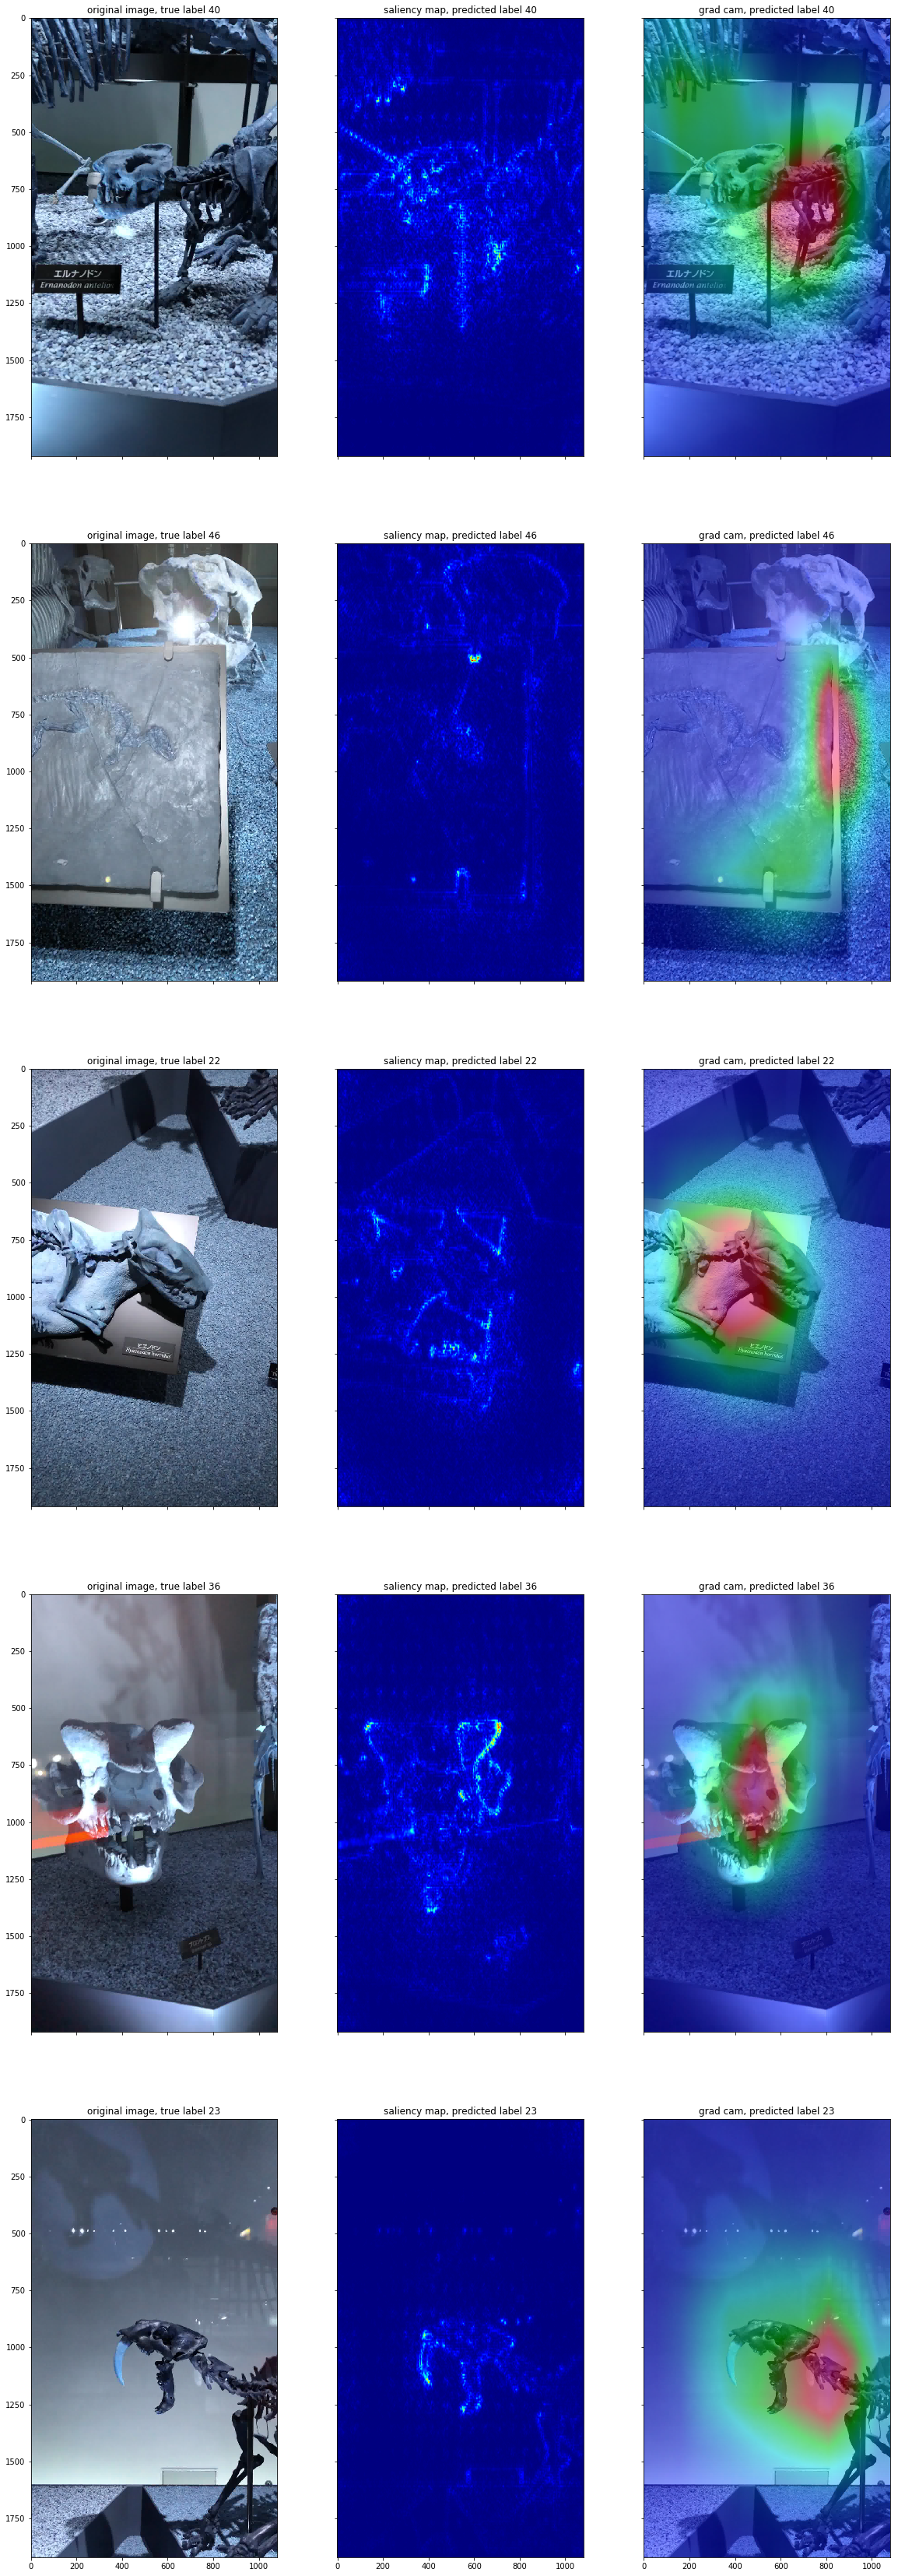

In [28]:
fig, ax = plt.subplots(5, 3, sharex = 'col', sharey = 'row', figsize = (20, 60))

for i in range(5):
    for j in range(3):
        
        if j == 1:
            # saliency
            grads = visualize_saliency(model, layer_idx, filter_indices = pred_label[i], 
                                       seed_input = load_img(img_path[i]), backprop_modifier = 'guided')
            # resize to original image size
            img = cv2.imread(img_path[i])
            grads_resized = cv2.resize(grads, (img.shape[1], img.shape[0]))
            # visualize grads as heatmap
            ax[i, j].imshow(grads_resized, cmap = 'jet')
            ax[i, j].set_title('saliency map, predicted label {}'.format(pred_label[i] + 1))
        
        elif j == 2:
            # grad cam
            gradcam = get_grad_cam(pred_label[i], load_img(img_path[i]), img_path[i])
            # visualize grads as heatmap
            ax[i, j].imshow(gradcam)
            ax[i, j].set_title('grad cam, predicted label {}'.format(pred_label[i] + 1))
        
        else:
            img = cv2.imread(img_path[i])
            ax[i, j].imshow(img)
            ax[i, j].set_title('original image, true label {}'.format(int(classes[i])))
            